In [1]:
%load_ext rpy2.ipython

In [70]:
%%R
library(dplyr)
library(reshape)
library(ggplot2)
library(RColorBrewer)
library(DESeq2)
library(wesanderson)
library(phyloseq)

In [3]:
%%R
d = read.csv("LCMSPeakAreas.csv")

In [4]:
%%R
d.melt = melt(d, id=c("POSname","NEGname","CommonName","Trtmt","Day"))
colnames(d.melt) = c("POSname","NEGname","CommonName","Trtmt","Day","Cmpd","PeakArea")
head(d.melt)

       POSname      NEGname CommonName Trtmt Day                    Cmpd
1 29S_POS.mzML 29S_NEG.mzML  Bulk_soil     X   0 alpha.ketoglutaric.acid
2 49S_POS.mzML 49S_NEG.mzML  Bulk_soil     X   0 alpha.ketoglutaric.acid
3  9S_POS.mzML  9S_NEG.mzML  Bulk_soil     X   0 alpha.ketoglutaric.acid
4  1S_POS.mzML  1S_NEG.mzML  Root_1day     X   1 alpha.ketoglutaric.acid
5 21S_POS.mzML 21S_NEG.mzML  Root_1day     X   1 alpha.ketoglutaric.acid
6 41S_POS.mzML 41S_NEG.mzML  Root_1day     X   1 alpha.ketoglutaric.acid
   PeakArea
1  87156.05
2 160549.82
3 116702.72
4 192482.52
5 193805.77
6 226529.51


In [5]:
%%R
#write.csv(d.melt, "LCMSPeakAreaStacked.csv")
# Don't do this - it's saved with classifications, etc.

NULL


In [6]:
%%R
d.melt = read.csv("LCMSPeakAreaStacked.csv")

In [7]:
%%R
d.melt.rm = d.melt[d.melt$NEGname!="21S_NEG.mzML",]
# Removing a consistent outlier to get a better look at the trends

In [8]:
%%R
head(d.melt.rm)

  X.1 X      POSname      NEGname CommonName Trtmt Day                    Cmpd
1   1 1 29S_POS.mzML 29S_NEG.mzML  Bulk_soil     X   0 alpha.ketoglutaric.acid
2   2 2 49S_POS.mzML 49S_NEG.mzML  Bulk_soil     X   0 alpha.ketoglutaric.acid
3   3 3  9S_POS.mzML  9S_NEG.mzML  Bulk_soil     X   0 alpha.ketoglutaric.acid
4   4 4  1S_POS.mzML  1S_NEG.mzML  Root_1day     X   1 alpha.ketoglutaric.acid
6   6 6 41S_POS.mzML 41S_NEG.mzML  Root_1day     X   1 alpha.ketoglutaric.acid
7   7 7 23S_POS.mzML 23S_NEG.mzML  Root_2day     X   2 alpha.ketoglutaric.acid
  Class ContainsN  PeakArea
1    OA         N  87156.05
2    OA         N 160549.82
3    OA         N 116702.72
4    OA         N 192482.52
6    OA         N 226529.51
7    OA         N  96912.54


In [9]:
%%R
d.melt.rm$Class = plyr::revalue(d.melt.rm$Class, c("AA"="Amino Acid", "N"="Urea","Nt"="Nucleotide", "OA"="Organic acid","PhAl"="Vanillin","SA"="Sugar", "SAC"="Sugar","SACOH"="Mannitol", "X"="Other"))
# Writing out the full classes
d.melt.rm$Day = as.factor(d.melt.rm$Day)
d.melt.rm$Day = plyr::revalue(d.melt.rm$Day, c("0"="0","1"="1", "2"="2","3.5"="3", "5.5"="5","7.5"="7"))


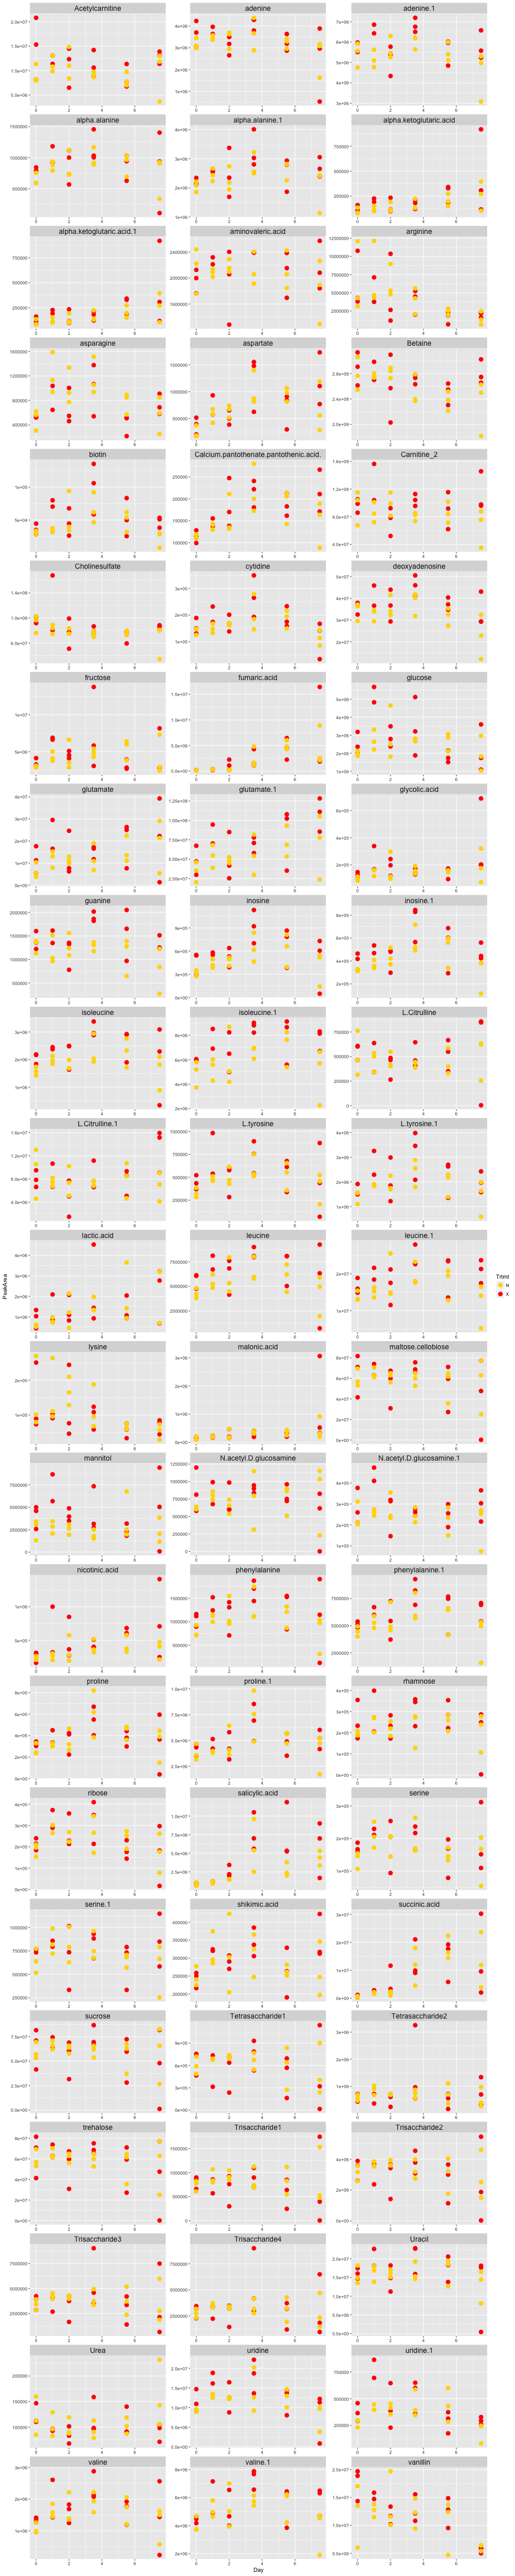

In [8]:
%%R -w 1000 -h 5000
p = ggplot(d.melt.rm, aes(x=Day,y=PeakArea, colour=Trtmt))
p = p + geom_point(size = 3.5)
p = p + facet_wrap(~Cmpd,scales="free", ncol=3)
p = p + theme(strip.text = element_text(size=14))
p = p + scale_colour_manual(values=c("gold1","red"))
p

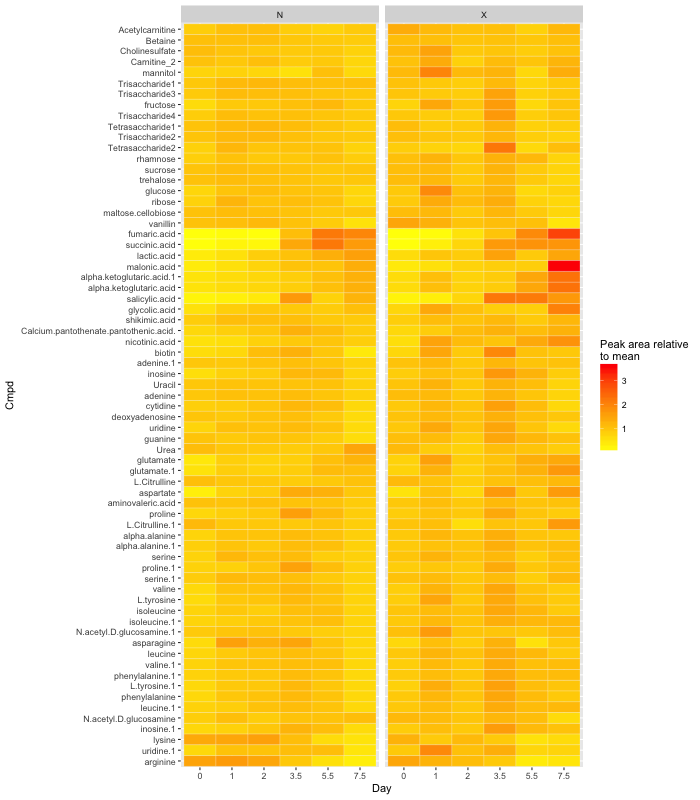

In [399]:
%%R -w 700 -h 800

d.melt.rm.map = d.melt.rm %>%
    group_by(Trtmt,Day,Class,Cmpd)%>%
    summarize(Mean = mean(PeakArea))%>%
    group_by(Cmpd)%>%
    mutate(PeakAreaScaled = Mean / mean(Mean))
# Creates a new value that is the mean value for each compound, under each treatment and day
# and rescales it by the mean of all of that compound across treatment/days.

d.melt.rm.map$TrtmtDay = paste(paste(d.melt.rm.map$Trtmt),paste(d.melt.rm.map$Day),sep="")
d.melt.rm.map$Day = as.factor(d.melt.rm.map$Day)

d.7.5 = d.melt.rm.map[d.melt.rm.map$Day=="7.5",]
Cmpd.order = d.7.5[order(d.7.5$Class,d.7.5$PeakAreaScaled),]$Cmpd
d.melt.rm.map$Cmpd = ordered(d.melt.rm.map$Cmpd, levels = Cmpd.order)
levels(d.melt.rm.map$Cmpd)
# Ordering the compounds by their final abundance

p = ggplot(d.melt.rm.map, aes(Day, Cmpd))
p = p + geom_tile(aes(fill = PeakAreaScaled), colour = "white")
p = p + scale_fill_gradient2(low = "white", mid = "yellow", high = "red",
                            guide = guide_colourbar(title = c("Peak area relative\nto mean")))
p = p + facet_wrap(~Trtmt)
p

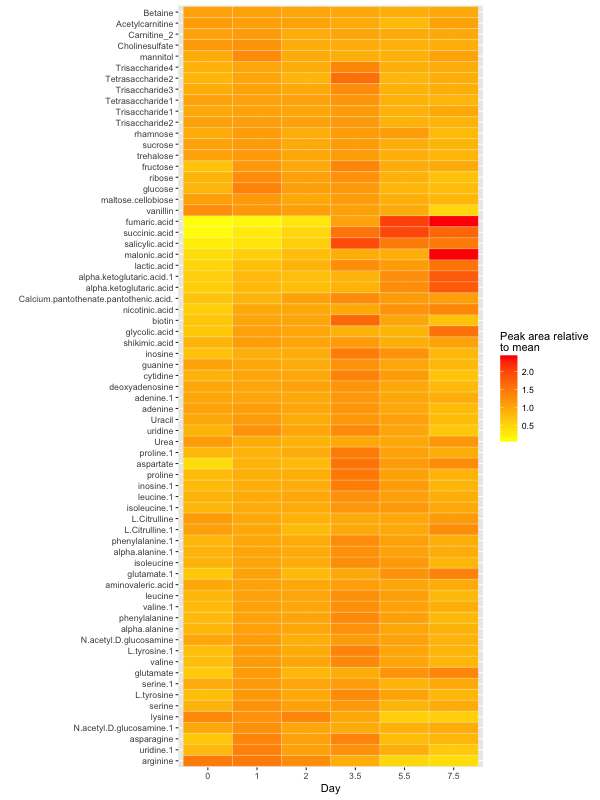

In [400]:
%%R -w 600 -h 800

d.melt.rm.map = d.melt.rm %>%
    group_by(Day,Class,Cmpd)%>%
    summarize(Mean = mean(PeakArea))%>%
    group_by(Class,Cmpd)%>%
    #mutate(Baseline = Mean[Day==3.5])%>%
    mutate(Baseline = mean(Mean))%>%
    mutate(PeakAreaScaled = Mean / Baseline)
#    filter(Class!="OA")
# Creates a new value that is the mean value for each compound, under each treatment and day
# and rescales it by the mean of all of that compound across treatment/days.

d.melt.rm.map$Day = as.factor(d.melt.rm.map$Day)
# Making Day a factor, not a continuous number

d.7.5 = d.melt.rm.map[d.melt.rm.map$Day=="1",]
Cmpd.order = d.7.5[order(d.7.5$Class,-d.7.5$PeakAreaScaled),]$Cmpd
d.melt.rm.map$Cmpd = ordered(d.melt.rm.map$Cmpd, levels = Cmpd.order)
levels(d.melt.rm.map$Cmpd)
# Ordering the compounds by their final abundance

p = ggplot(d.melt.rm.map, aes(Day, Cmpd))
p = p + geom_tile(aes(fill = PeakAreaScaled), colour = "white")
p = p + scale_fill_gradient2(low = "white", mid = "yellow", high = "red",
                            guide = guide_colourbar(title = c("Peak area relative\nto mean")))
#p = p + scale_fill_gradientn(colours=rainbow(10))
#p = p + scale_fill_gradientn(colours=topo.colors(10))

p = p + ylab("")
p

This gives rough abundance of a given compound.  
We extracted the same amount of soil, the same way, with the same water ratios.  
Thus, an increase should be a real increase, not just a proportional increase.  
Are we interested in looking at proportions? The numbers could be scaled by DOC.  
However, that doesn't necessarily improve our understanding.

In [401]:
%%R
head(d.melt.rm)

  X.1 X      POSname      NEGname CommonName Trtmt Day                    Cmpd
1   1 1 29S_POS.mzML 29S_NEG.mzML  Bulk_soil     X   0 alpha.ketoglutaric.acid
2   2 2 49S_POS.mzML 49S_NEG.mzML  Bulk_soil     X   0 alpha.ketoglutaric.acid
3   3 3  9S_POS.mzML  9S_NEG.mzML  Bulk_soil     X   0 alpha.ketoglutaric.acid
4   4 4  1S_POS.mzML  1S_NEG.mzML  Root_1day     X   1 alpha.ketoglutaric.acid
6   6 6 41S_POS.mzML 41S_NEG.mzML  Root_1day     X   1 alpha.ketoglutaric.acid
7   7 7 23S_POS.mzML 23S_NEG.mzML  Root_2day     X   2 alpha.ketoglutaric.acid
  Class ContainsN  PeakArea
1    OA         N  87156.05
2    OA         N 160549.82
3    OA         N 116702.72
4    OA         N 192482.52
6    OA         N 226529.51
7    OA         N  96912.54


In [402]:
%%R 

d.melt.rm.map = d.melt.rm %>%
    group_by(Class,Trtmt,Cmpd,ContainsN)%>%
    summarize(Mean = mean(PeakArea))%>%
    group_by(Cmpd,ContainsN)%>%
    mutate(Baseline = mean(Mean[Trtmt=="X"]))%>%
    mutate(PeakAreaScaled = Mean / Baseline)%>%
    filter(Trtmt=="N")
# For each day, gets the ratio of the mean value of the compound with N to w/o N (peak area)


d.7.5 = d.melt.rm.map
Cmpd.order = d.7.5[order(d.7.5$ContainsN,-d.7.5$PeakAreaScaled),]$Cmpd
d.melt.rm.map$Cmpd = ordered(d.melt.rm.map$Cmpd, levels = Cmpd.order)
# Ordering the compounds by their final abundance


In [403]:
%%R
head(d.melt.rm.map)

Source: local data frame [6 x 7]
Groups: Cmpd, ContainsN [6]

   Class  Trtmt              Cmpd ContainsN      Mean  Baseline PeakAreaScaled
  <fctr> <fctr>             <ord>    <fctr>     <dbl>     <dbl>          <dbl>
1     AA      N     alpha.alanine         Y  831097.3  926152.7      0.8973653
2     AA      N   alpha.alanine.1         Y 2359635.9 2630186.9      0.8971362
3     AA      N aminovaleric.acid         Y 2075378.3 2121036.4      0.9784737
4     AA      N          arginine         Y 4637848.6 3928663.1      1.1805158
5     AA      N        asparagine         Y  871219.2  687768.1      1.2667340
6     AA      N         aspartate         Y  685509.2  793494.5      0.8639118


/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

  warnings.warn(x, RRuntimeWarning)


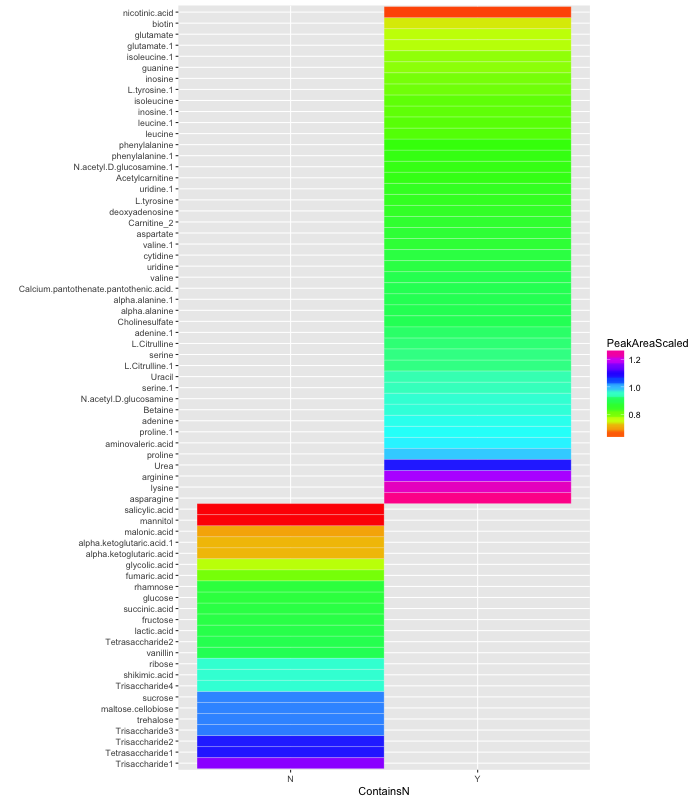

In [404]:
%%R -w 700 -h 800
p = ggplot(d.melt.rm.map, aes(ContainsN,Cmpd))
p = p + geom_tile(aes(fill = PeakAreaScaled), colour = "white")
p = p + scale_fill_gradient2(low = "white", mid = "yellow", high = "red",
                            guide = guide_colourbar(title = c("N vs X ratio")))
p = p + scale_fill_gradientn(colours=rainbow(10))
#p = p + scale_fill_gradientn(colours=topo.colors(10))
p = p + ylab("")
#p = p + facet_wrap(~ContainsN)
p
# This figure gives an idea of whether N affected different compounds differently on
# different days

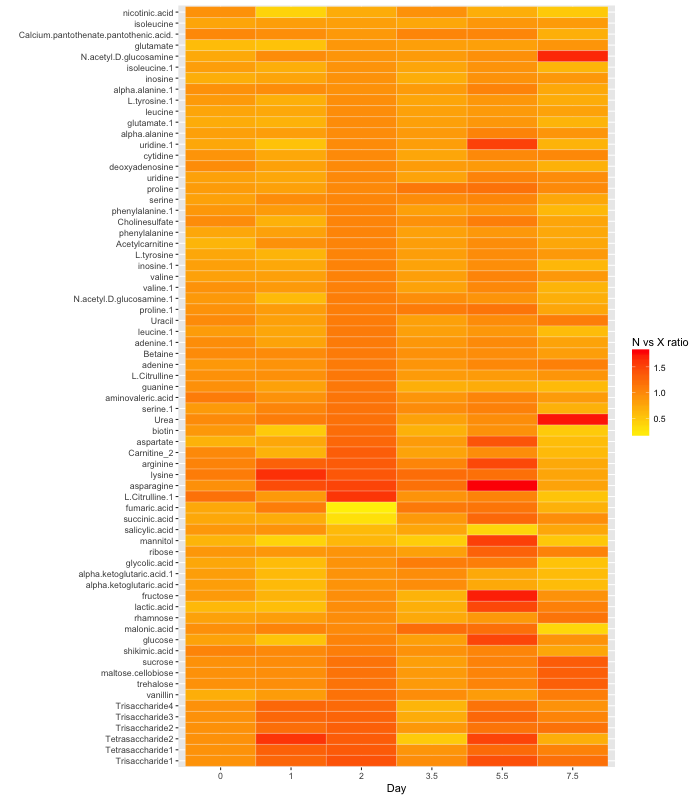

In [405]:
%%R -w 700 -h 800

d.melt.rm.map = d.melt.rm %>%
    group_by(Day,Class,Trtmt,Cmpd,ContainsN)%>%
    summarize(Mean = mean(PeakArea))%>%
    group_by(Day,Cmpd,ContainsN)%>%
    mutate(Baseline = mean(Mean[Trtmt=="X"]))%>%
    mutate(PeakAreaScaled = Mean / Baseline)%>%
    filter(Trtmt=="N")
# For each day, gets the ratio of the mean value of the compound with N to w/o N (peak area)

d.melt.rm.map$Day = as.factor(d.melt.rm.map$Day)
# Making Day a factor, not a continuous number

d.7.5 = d.melt.rm.map[d.melt.rm.map$Day=="2",]
Cmpd.order = d.7.5[order(d.7.5$ContainsN,-d.7.5$PeakAreaScaled),]$Cmpd
d.melt.rm.map$Cmpd = ordered(d.melt.rm.map$Cmpd, levels = Cmpd.order)
levels(d.melt.rm.map$Cmpd)
# Ordering the compounds by their final abundance

p = ggplot(d.melt.rm.map, aes(Day, Cmpd))
p = p + geom_tile(aes(fill = PeakAreaScaled), colour = "white")
p = p + scale_fill_gradient2(low = "white", mid = "yellow", high = "red",
                            guide = guide_colourbar(title = c("N vs X ratio")))
#p = p + scale_fill_gradientn(colours=rainbow(10))
#p = p + scale_fill_gradientn(colours=topo.colors(10))
p = p + ylab("")
#p = p + facet_wrap(~ContainsN)
p
# This figure gives an idea of whether N affected different compounds differently on
# different days

###Trying Z scores instead of relative to mean so we can see larger changes

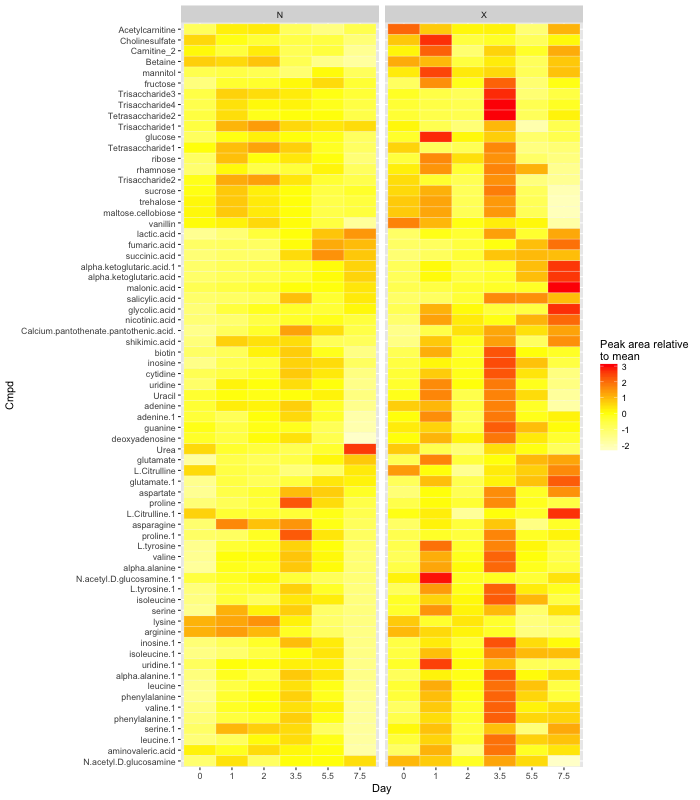

In [406]:
%%R -w 700 -h 800

d.melt.rm.map = d.melt.rm %>%
    group_by(Trtmt,Day,Class,Cmpd)%>%
    summarize(Mean = mean(PeakArea))%>%
    group_by(Cmpd)%>%
    mutate(PeakAreaScaledZ = (Mean - mean(Mean))/sd(Mean))
# Creates a new value that is the mean value for each compound, under each treatment and day
# and rescales it by the mean of all of that compound across treatment/days.

d.melt.rm.map$TrtmtDay = paste(paste(d.melt.rm.map$Trtmt),paste(d.melt.rm.map$Day),sep="")
d.melt.rm.map$Day = as.factor(d.melt.rm.map$Day)

d.7.5 = d.melt.rm.map[d.melt.rm.map$Day=="7.5",]
Cmpd.order = d.7.5[order(d.7.5$Class,d.7.5$PeakAreaScaledZ),]$Cmpd
d.melt.rm.map$Cmpd = ordered(d.melt.rm.map$Cmpd, levels = Cmpd.order)
levels(d.melt.rm.map$Cmpd)
# Ordering the compounds by their final abundance

p = ggplot(d.melt.rm.map, aes(Day, Cmpd))
p = p + geom_tile(aes(fill = PeakAreaScaledZ), colour = "white")
p = p + scale_fill_gradient2(low = "white", mid = "yellow", high = "red",
                            guide = guide_colourbar(title = c("Peak area relative\nto mean")))
p = p + facet_wrap(~Trtmt)
p

### Making combined heatmaps with metabolite types identified

/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Using PeakAreaScaled as value column.  Use the value argument to cast to override this choice

  warnings.warn(x, RRuntimeWarning)


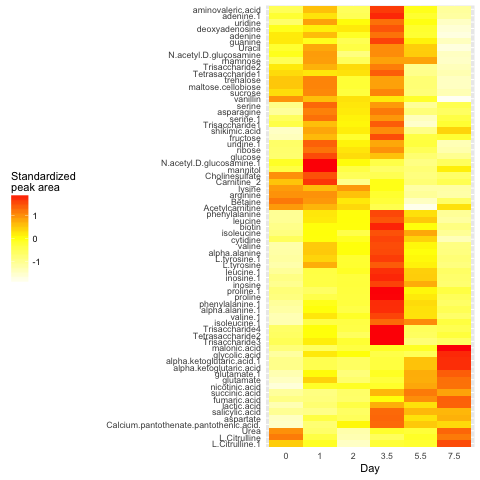

In [407]:
%%R
### Figuring out how to organize the y-axis by clustered metabolites to show trends

d.melt.rm.map = d.melt.rm %>%
    group_by(Day,Class,Cmpd)%>%
    summarize(Mean = mean(PeakArea))%>%
    group_by(Class,Cmpd)%>%
    mutate(Baseline = mean(Mean))%>%
    mutate(PeakAreaScaled = (Mean - Baseline)/sd(Mean))
# Creates a new value that is the mean value for each compound, under each treatment and day
# and rescales it by the Z scores.

d.melt.rm.map.dist = cast(d.melt.rm.map, Day~Cmpd)
row.names(d.melt.rm.map.dist) = d.melt.rm.map.dist$Day
d.melt.rm.map.dist =d.melt.rm.map.dist[,2:dim(d.melt.rm.map.dist)[2]] 
# Now we have a data frame ready for clustering.

order = hclust(dist(t(d.melt.rm.map.dist), method = "euclidean"), method = "ward.D" )$order
# This should create the ordering to make clusters by compound behaviour

d.melt.rm.map$Cmpd = ordered(d.melt.rm.map$Cmpd, levels=levels(d.melt.rm.map$Cmpd)[order])
# Clustering by compound behaviour

d.melt.rm.map$Day = as.factor(d.melt.rm.map$Day)
# Making Day a factor, not a continuous number

p = ggplot(d.melt.rm.map, aes(Day, Cmpd))
p = p + geom_tile(aes(fill = PeakAreaScaled))
p = p + scale_fill_gradient2(low = "white", mid = "yellow", high = "red",
                            guide = guide_colourbar(title = c("Standardized\npeak area")))

p = p + ylab("") + theme(legend.position="left",axis.ticks = element_blank())


p

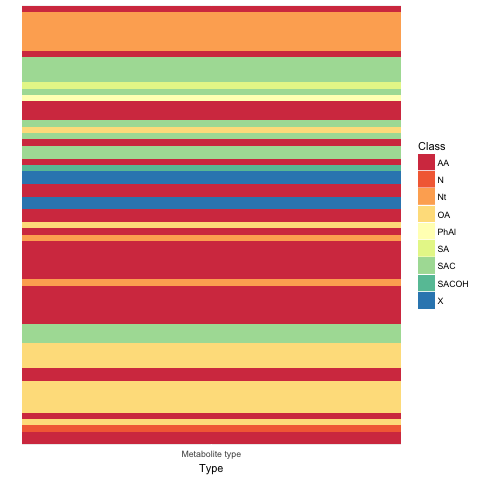

In [408]:
%%R
CmpdClass = d.melt.rm[,c(8,9,10)]
CmpdClass = subset(CmpdClass,!duplicated(CmpdClass$Cmpd))
CmpdClass$Cmpd = ordered(CmpdClass$Cmpd, levels=levels(CmpdClass$Cmpd)[order])
CmpdClass$Type = rep.int("Metabolite type",length(CmpdClass$Cmpd))
p1 = ggplot(CmpdClass, aes(Type, Cmpd))
p1 = p1 + geom_tile(aes(fill = Class))
Colours = brewer.pal(9, "Spectral")
p1 = p1 + scale_fill_manual(values=Colours)
p1 = p1 + ylab("")
p1 = p1 + theme(axis.ticks = element_blank(), axis.text.y = element_blank())
p1

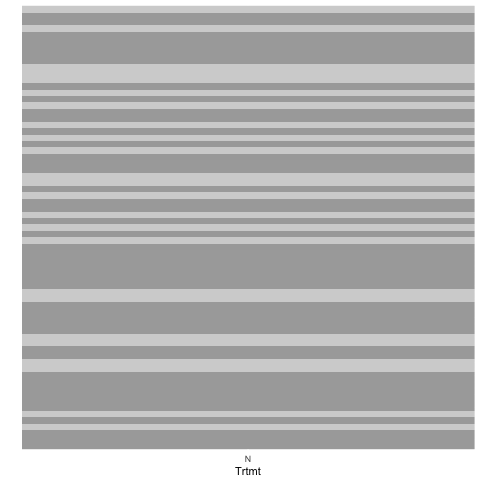

In [409]:
%%R
Nstatus = d.melt.rm[,c(8,9,10)]
Nstatus = subset(Nstatus,!duplicated(Nstatus$Cmpd))
Nstatus$Cmpd = ordered(CmpdClass$Cmpd, levels=levels(CmpdClass$Cmpd)[order])
Nstatus$Trtmt = rep.int("N",length(Nstatus$ContainsN))
p2 = ggplot(Nstatus, aes(Trtmt, Cmpd))
p2 = p2 + geom_tile(aes(fill = ContainsN))
Colours = c("lightgrey","darkgrey")
p2 = p2 + scale_fill_manual(values=Colours, guide=FALSE)
p2 = p2 + ylab("")
p2 = p2 + theme(axis.ticks = element_blank(), axis.text.y = element_blank())
p2

/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: gridExtra

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘gridExtra’


  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:Biobase’:

    combine


  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:BiocGenerics’:

    combine


  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:dplyr’:

    combine


  warnings.warn(x, RRuntimeWarning)


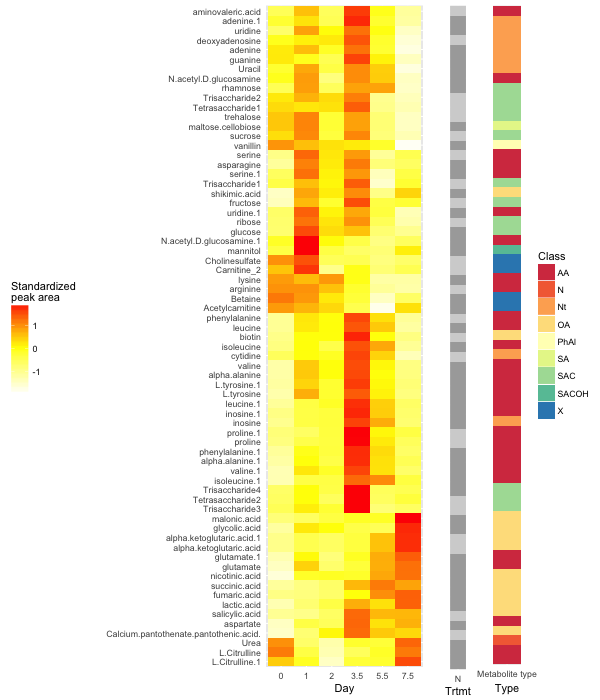

In [410]:
%%R -w 600 -h 700
require(gridExtra)
grid.arrange(p, p2, p1, ncol=3, nrow=1, widths = c(5,0.5,1.5))
# We'll want to redo this with the N effects included, probably.

## Running it separately for two N statuses

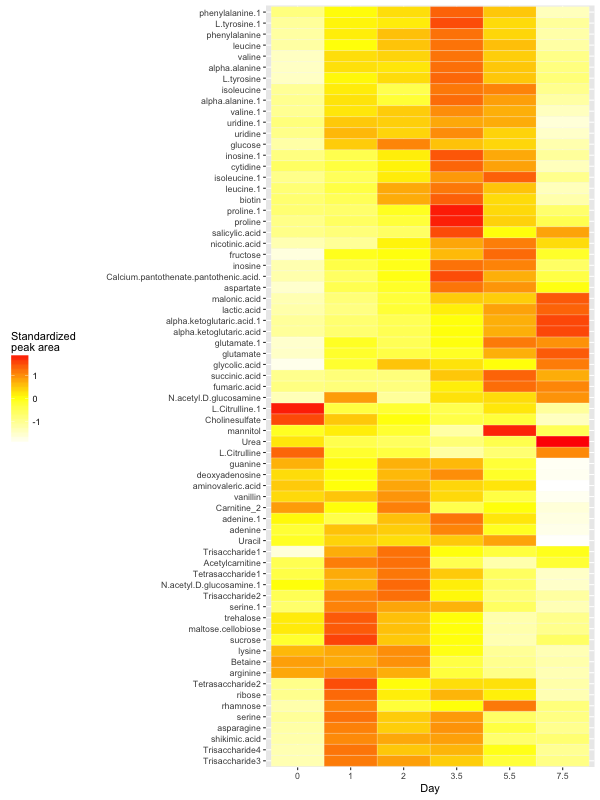

In [411]:
%%R -w 600 -h 800
### Figuring out how to organize the y-axis by clustered metabolites to show trends
d.melt.rm.N = d.melt.rm %>%
    filter(Trtmt == "N")

d.melt.rm.map = d.melt.rm.N %>%
    group_by(Day,Class,Cmpd)%>%
    summarize(Mean = mean(PeakArea))%>%
    group_by(Class,Cmpd)%>%
    mutate(Baseline = mean(Mean))%>%
    mutate(PeakAreaScaled = (Mean - Baseline)/sd(Mean))
# Creates a new value that is the mean value for each compound, under each treatment and day
# and rescales it by the Z scores.

d.melt.rm.map.dist = cast(d.melt.rm.map, Day~Cmpd)
row.names(d.melt.rm.map.dist) = d.melt.rm.map.dist$Day
d.melt.rm.map.dist =d.melt.rm.map.dist[,2:dim(d.melt.rm.map.dist)[2]] 
# Now we have a data frame ready for clustering.

order = hclust(dist(t(d.melt.rm.map.dist), method = "euclidian"), method = "ward.D" )$order
# This should create the ordering to make clusters by compound behaviour

d.melt.rm.map$Cmpd = ordered(d.melt.rm.map$Cmpd, levels=levels(d.melt.rm.map$Cmpd)[order])
# Clustering by compound behaviour

d.melt.rm.map$Day = as.factor(d.melt.rm.map$Day)
# Making Day a factor, not a continuous number

p = ggplot(d.melt.rm.map, aes(Day, Cmpd))
p = p + geom_tile(aes(fill = PeakAreaScaled), colour = "white")
p = p + scale_fill_gradient2(low = "white", mid = "yellow", high = "red",
                            guide = guide_colourbar(title = c("Standardized\npeak area")))

p = p + ylab("") + theme(legend.position="left")

p

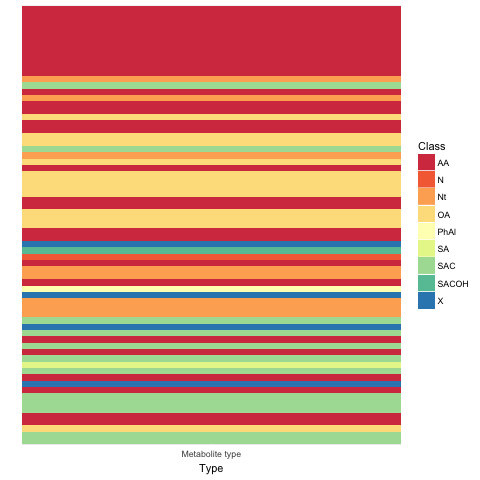

In [412]:
%%R
CmpdClass = d.melt.rm.N[,c(8,9,10)]
CmpdClass = subset(CmpdClass,!duplicated(CmpdClass$Cmpd))
CmpdClass$Cmpd = ordered(CmpdClass$Cmpd, levels=levels(CmpdClass$Cmpd)[order])
CmpdClass$Type = rep.int("Metabolite type",length(CmpdClass$Cmpd))
p1 = ggplot(CmpdClass, aes(Type, Cmpd))
p1 = p1 + geom_tile(aes(fill = Class))
Colours = brewer.pal(9, "Spectral")
p1 = p1 + scale_fill_manual(values=Colours)
p1 = p1 + ylab("")
p1 = p1 + theme(axis.ticks = element_blank(), axis.text.y = element_blank())
p1

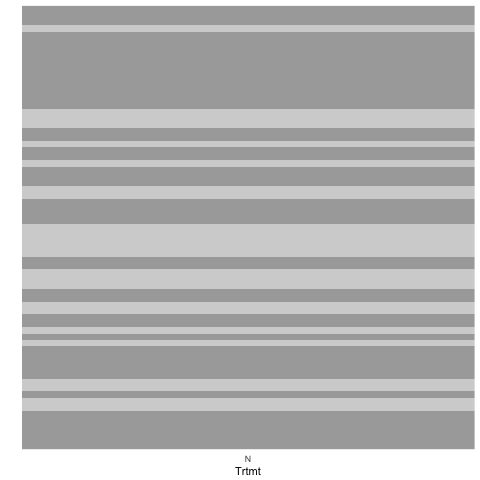

In [413]:
%%R
Nstatus = d.melt.rm.N[,c(8,9,10)]
Nstatus = subset(Nstatus,!duplicated(Nstatus$Cmpd))
Nstatus$Cmpd = ordered(CmpdClass$Cmpd, levels=levels(CmpdClass$Cmpd)[order])
Nstatus$Trtmt = rep.int("N",length(Nstatus$ContainsN))
p2 = ggplot(Nstatus, aes(Trtmt, Cmpd))
p2 = p2 + geom_tile(aes(fill = ContainsN))
Colours = c("lightgrey","darkgrey")
p2 = p2 + scale_fill_manual(values=Colours, guide=FALSE)
p2 = p2 + ylab("")
p2 = p2 + theme(axis.ticks = element_blank(), axis.text.y = element_blank())
p2

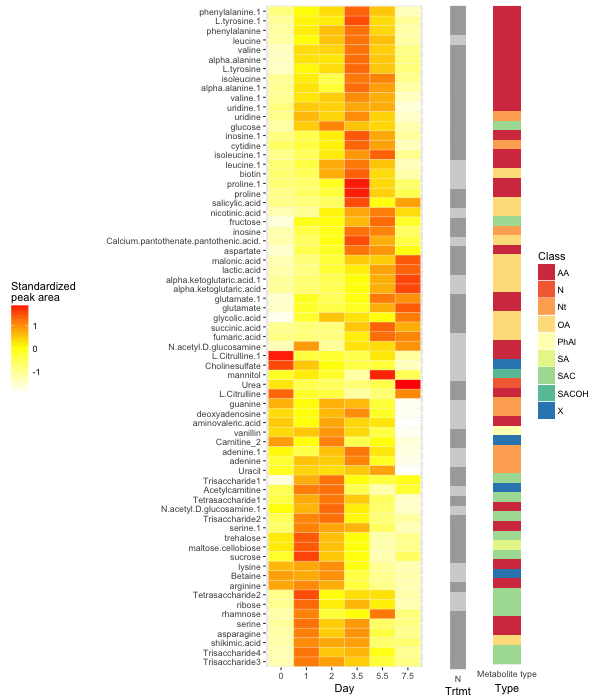

In [414]:
%%R -w 600 -h 700
require(gridExtra)
grid.arrange(p, p2, p1, ncol=3, widths = c(5,0.5,1.5))
# Plot is for samples with N additions

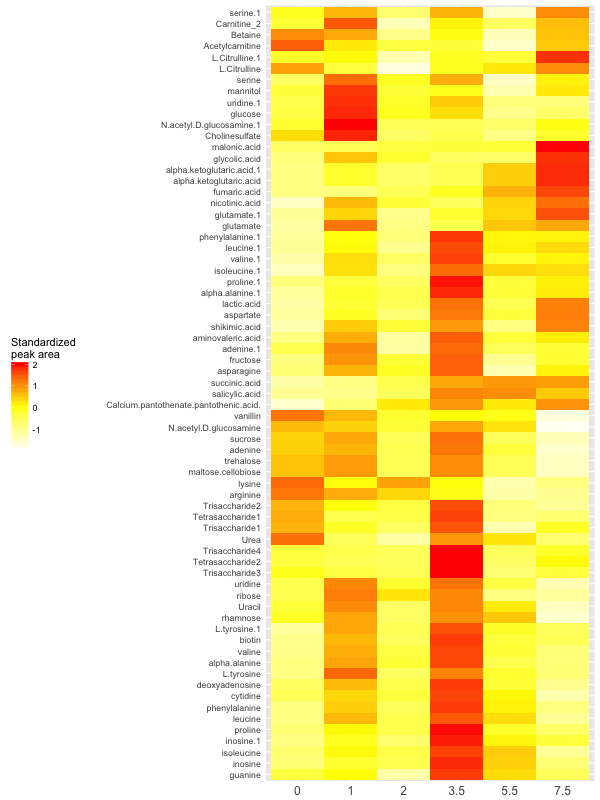

In [415]:
%%R -w 600 -h 800
### Figuring out how to organize the y-axis by clustered metabolites to show trends
d.melt.rm.X = d.melt.rm %>%
    filter(Trtmt == "X")

d.melt.rm.map = d.melt.rm.X %>%
    group_by(Day,Class,Cmpd)%>%
    summarize(Mean = mean(PeakArea))%>%
    group_by(Class,Cmpd)%>%
    mutate(Baseline = mean(Mean))%>%
    mutate(PeakAreaScaled = (Mean - Baseline)/sd(Mean))
# Creates a new value that is the mean value for each compound, under each treatment and day
# and rescales it by the Z scores.

d.melt.rm.map.dist = cast(d.melt.rm.map, Day~Cmpd)
row.names(d.melt.rm.map.dist) = d.melt.rm.map.dist$Day
d.melt.rm.map.dist =d.melt.rm.map.dist[,2:dim(d.melt.rm.map.dist)[2]] 
# Now we have a data frame ready for clustering.

order = hclust(dist(t(d.melt.rm.map.dist), method = "euclidean"), method = "ward.D" )$order
# This should create the ordering to make clusters by compound behaviour
# distance method could also be manhattan

d.melt.rm.map$Cmpd = ordered(d.melt.rm.map$Cmpd, levels=levels(d.melt.rm.map$Cmpd)[order])
# Clustering by compound behaviour

d.melt.rm.map$Day = as.factor(d.melt.rm.map$Day)
# Making Day a factor, not a continuous number

p = ggplot(d.melt.rm.map, aes(Day, Cmpd))
p = p + geom_tile(aes(fill = PeakAreaScaled))
p = p + scale_fill_gradient2(low = "white", mid = "yellow", high = "red",
                            guide = guide_colourbar(title = c("Standardized\npeak area")))

p = p + ylab("") + theme(legend.position="left", axis.ticks = element_blank(), axis.title.x = element_blank(),
                        axis.text.x = element_text(size=12))


p

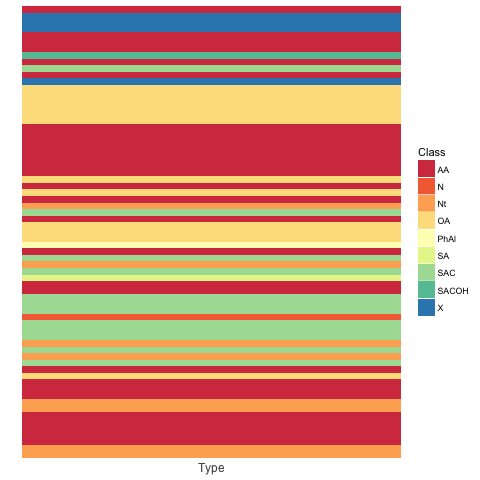

In [416]:
%%R
CmpdClass = d.melt.rm.X[,c(8,9,10)]
CmpdClass = subset(CmpdClass,!duplicated(CmpdClass$Cmpd))
CmpdClass$Cmpd = ordered(CmpdClass$Cmpd, levels=levels(CmpdClass$Cmpd)[order])
CmpdClass$Type = rep.int("Type",length(CmpdClass$Cmpd))
p1 = ggplot(CmpdClass, aes(Type, Cmpd))
p1 = p1 + geom_tile(aes(fill = Class))
Colours = brewer.pal(9, "Spectral")
p1 = p1 + scale_fill_manual(values=Colours)
p1 = p1 + ylab("")
p1 = p1 + theme(axis.ticks = element_blank(), axis.text.y = element_blank(), axis.title.x = element_blank(),
               axis.text.x = element_text(size=12))
p1

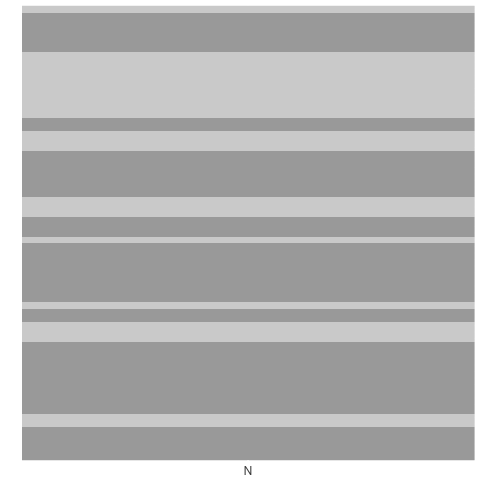

In [417]:
%%R
Nstatus = d.melt.rm.X[,c(8,9,10)]
Nstatus = subset(Nstatus,!duplicated(Nstatus$Cmpd))
CmpdClass$Cmpd = ordered(CmpdClass$Cmpd, levels=levels(CmpdClass$Cmpd)[order])
Nstatus$Trtmt = rep.int("N",length(Nstatus$ContainsN))
p2 = ggplot(Nstatus, aes(Trtmt, Cmpd))
p2 = p2 + geom_tile(aes(fill = ContainsN))
Colours = c("lightgrey","darkgrey")
p2 = p2 + scale_fill_manual(values=Colours, guide=FALSE)
p2 = p2 + ylab("")
p2 = p2 + theme(axis.ticks = element_blank(), axis.text.y = element_blank(), axis.title.x = element_blank(),
               axis.text.x = element_text(size=12))
p2

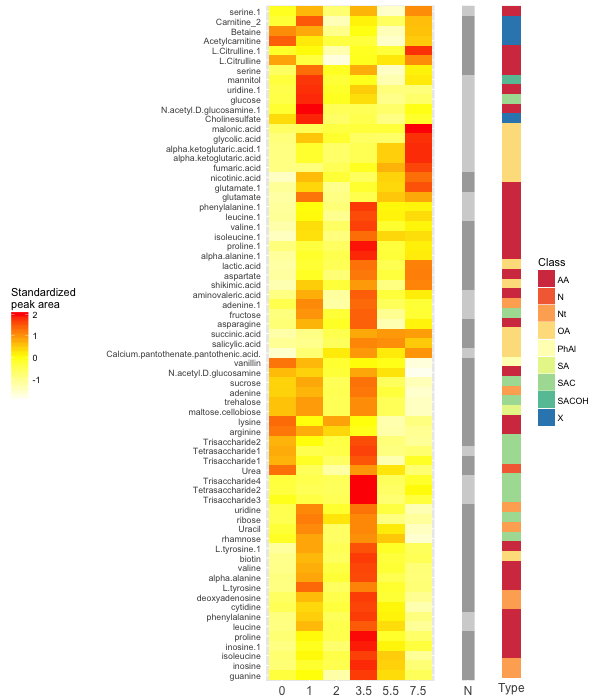

In [418]:
%%R -w 600 -h 700
require(gridExtra)
grid.arrange(p, p2, p1, ncol=3, widths = c(5.5,0.5,1.5))
# Plot is for samples without N additions

### Plotting each metabolite over time

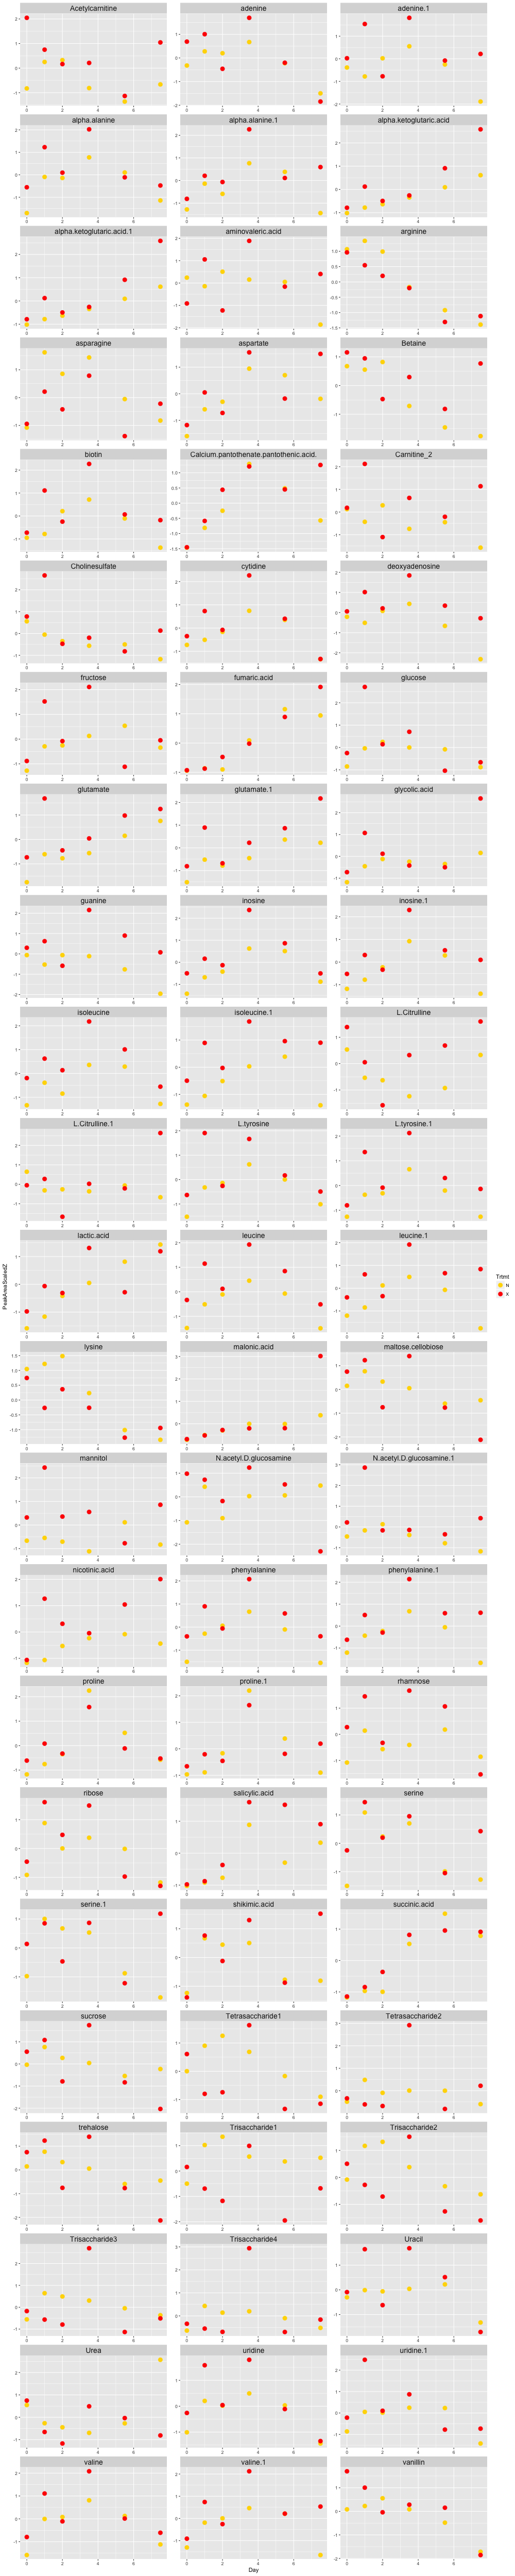

In [419]:
%%R -w 1000 -h 5000
d.melt.rm.map = d.melt.rm %>%
    group_by(Trtmt,Day,Class,Cmpd)%>%
    summarize(Mean = mean(PeakArea))%>%
    group_by(Cmpd)%>%
    mutate(PeakAreaScaledZ = (Mean - mean(Mean))/sd(Mean))

p = ggplot(d.melt.rm.map, aes(x=Day,y=PeakAreaScaledZ, colour=Trtmt))
p = p + geom_point(size = 3.5)
p = p + facet_wrap(~Cmpd,scales="free", ncol=3)
p = p + theme(strip.text = element_text(size=14))
p = p + scale_colour_manual(values=c("gold1","red"))
p

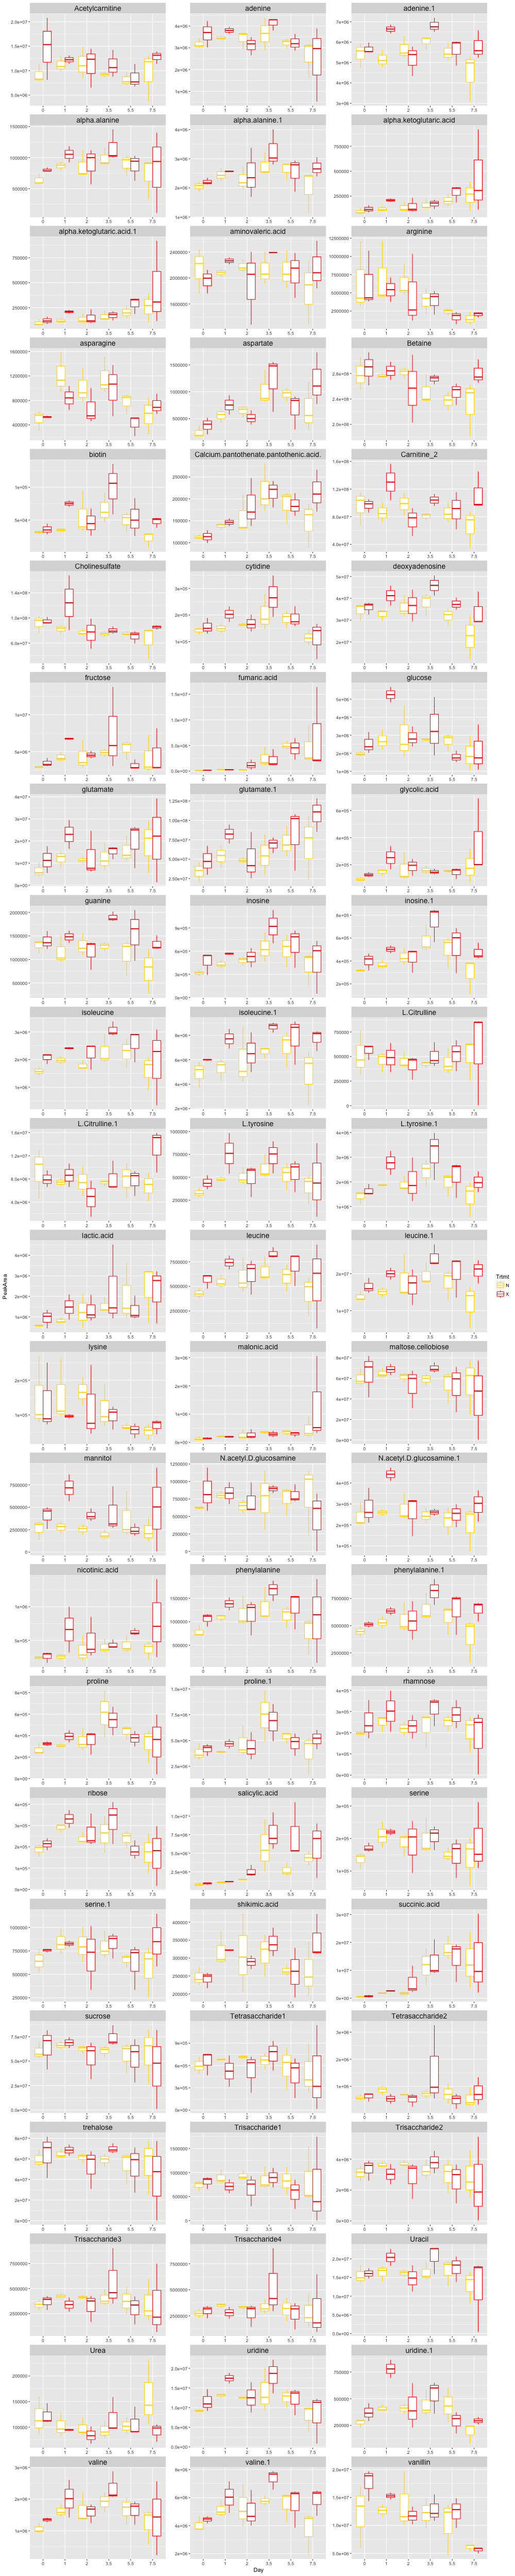

In [420]:
%%R -w 1000 -h 5000
d.melt.rm$Day = as.factor(d.melt.rm$Day)
p = ggplot(d.melt.rm, aes(x=Day,y=PeakArea, colour=Trtmt))
p = p + geom_boxplot()
p = p + facet_wrap(~Cmpd,scales="free", ncol=3)
p = p + theme(strip.text = element_text(size=14))
p = p + scale_colour_manual(values=c("gold1","red"))
p

## Phyloseq
What if we used DESeq2 to determine which compounds were enriched/depleted in N treatments?
I am seeing the compounds as OTUs, and their peak areas as their abundances.
Then, the samples should be the various X values, and the other columns are the sample data

In [12]:
%%R
d.melt.rm=d.melt.rm %>%
    filter(POSname!="63S_POS.mzML")
# Removing big outlier
dim(d.melt.rm)

[1] 2346   11


In [14]:
%%R
OTUTable = d.melt.rm[,c(3,8,11)]
OTUTable = data.frame(cast(OTUTable,Cmpd~POSname))
rownames(OTUTable) = OTUTable[,1]
OTUTable=OTUTable[,2:dim(OTUTable)[2]]
# Making the OTU table

SampleData = d.melt.rm[,c(3:7)]
SampleData=SampleData[!duplicated(SampleData),]
SampleData$RowNames = paste("X",SampleData$POSname,sep="")
rownames(SampleData) = SampleData$RowNames
SampleData$ID = paste(SampleData$Trtmt,SampleData$Day)

Taxonomy = d.melt.rm[,c(8:10)]%>%
    arrange(Cmpd)
Taxonomy=tax_table(Taxonomy[!duplicated(Taxonomy),])
colnames(Taxonomy)=c("Cmpd","Class","ContainsN")
taxa_names(Taxonomy) = rownames(OTUTable)

ps=phyloseq(otu_table(OTUTable,taxa_are_rows=TRUE), sample_data(SampleData), Taxonomy)

ps

/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Using PeakArea as value column.  Use the value argument to cast to override this choice

  warnings.warn(x, RRuntimeWarning)


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 69 taxa and 34 samples ]
sample_data() Sample Data:       [ 34 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 69 taxa by 3 taxonomic ranks ]


Ok, I think that's the phyloseq object we need.

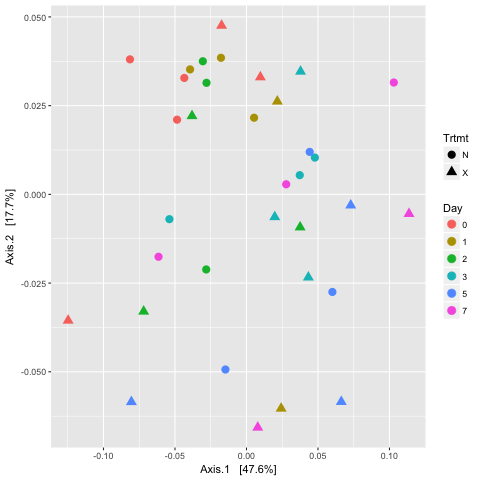

In [15]:
%%R
ps.norm = transform_sample_counts(ps,function(x) x/sum(x))
sample_data(ps.norm)$Day = as.factor(sample_data(ps.norm)$Day)
MyOrd = ordinate(ps.norm,"PCoA","bray")
plot_ordination(ps.norm,MyOrd,color="Day",shape="Trtmt") + geom_point(size=3.5)
    #+ geom_text(aes(label=POSname, size=14),hjust=-3)

Could be nice as a 3D plot.. doesn't really suggest an effect of N.

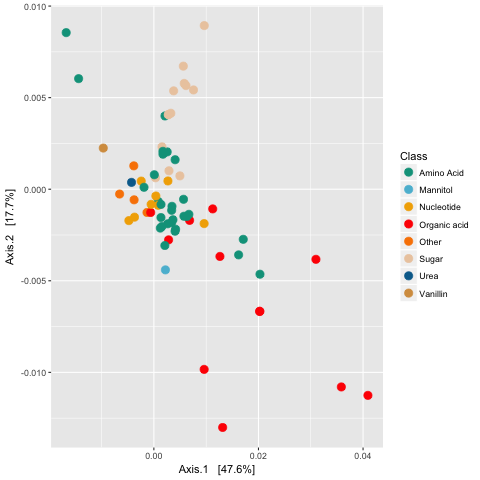

In [17]:
%%R

ps.norm = transform_sample_counts(ps,function(x) x/sum(x))
sample_data(ps.norm)$Day = as.factor(sample_data(ps.norm)$Day)
MyOrd = ordinate(ps.norm,"PCoA","bray")
Palette = c(wes_palette("Darjeeling")[c(2,5,3,1,4)],wes_palette("Darjeeling2"))
plot_ordination(ps.norm,MyOrd,type="taxa",color="Class") + geom_point(size=3.5) + scale_color_manual(values=Palette)
    #+ geom_text(aes(label=POSname, size=14),hjust=-3)

/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  Ignoring unknown aesthetics: shape, label

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  Ignoring unknown aesthetics: shape

  warnings.warn(x, RRuntimeWarning)


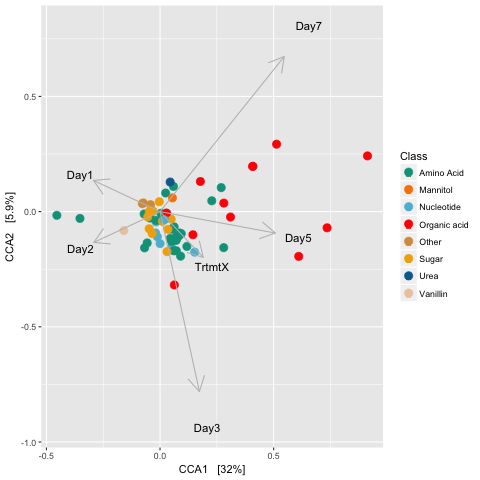

In [18]:
%%R
ps.norm = transform_sample_counts(ps,function(x) x/sum(x))
sample_data(ps.norm)$Day = as.factor(sample_data(ps.norm)$Day)
MyOrd = ordinate(ps.norm~Day+Trtmt,"CCA","bray")
Palette = c(wes_palette("Darjeeling"),wes_palette("Darjeeling2"))
Palette = Palette[c(2,4,5,1,8,3,7,6,9)]
p0 = plot_ordination(ps.norm,MyOrd,type="taxa",color="Class") + geom_point(size=3.5) + scale_color_manual(values=Palette)
    #+ geom_text(aes(label=POSname, size=14),hjust=-3)
    
arrowmat = vegan::scores(MyOrd, display = "bp")
# Add labels, make a data.frame
arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)
# Define the arrow aesthetic mapping
arrow_map = aes(xend = CCA1, yend = CCA2, x = 0, y = 0, shape = NULL, color = NULL, 
    label = labels)
label_map = aes(x = 1.2 * CCA1, y = 1.2 * CCA2, shape = NULL, color = NULL, 
    label = labels)
# Make a new graphic
arrowhead = arrow(length = unit(0.05, "npc"))
p1 = p0 + geom_segment(arrow_map, size = 0.5, data = arrowdf, color = "gray", 
    arrow = arrowhead) + geom_text(label_map, size = 4, data = arrowdf)
p1

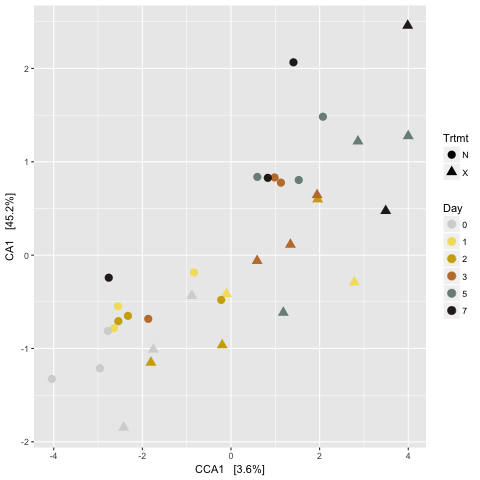

In [57]:
%%R
ps.norm = transform_sample_counts(ps,function(x) x/sum(x))
#ps.norm = ps
sample_data(ps.norm)$Day = as.factor(sample_data(ps.norm)$Day)
MyOrd = ordinate(ps.norm~Trtmt,"CCA","bray")
Palette2 = c(wes_palette("Moonrise1")[c(3,1,2)],wes_palette("Moonrise2")[c(2,1,4)])
p0 = plot_ordination(ps.norm,MyOrd,type="samples",color="Day", shape="Trtmt") + geom_point(size=3.5) + scale_color_manual(values=Palette2)
p0

In [60]:
%%R
MyOrd

Call: cca(formula = OTU ~ Trtmt, data = data)

               Inertia Proportion Rank
Total         0.052843   1.000000     
Constrained   0.001916   0.036259    1
Unconstrained 0.050927   0.963741   32
Inertia is mean squared contingency coefficient 

Eigenvalues for constrained axes:
    CCA1 
0.001916 

Eigenvalues for unconstrained axes:
     CA1      CA2      CA3      CA4      CA5      CA6      CA7      CA8 
0.023864 0.007069 0.005028 0.003487 0.002732 0.001942 0.001278 0.001134 
(Showed only 8 of all 32 unconstrained eigenvalues)



In [59]:
%%R
vegan::permutest(MyOrd, permutations = 1000, model="direct",by="margin")



Permutation test for cca 

Permutation: free
Number of permutations: 1000
 
Call: cca(formula = OTU ~ Trtmt, data = data)
Permutation test for all constrained eigenvalues
Pseudo-F:	 1.203939 (with 1, 32 Degrees of Freedom)
Significance:	 0.26274 



I think maybe I also want to test the OTU matrix against the metabolite matrix? But not sure if that's possible/appropriate or where it goes. But seems like a goal - how to link those datasets? The challenge is the reps are lost, as the reps were different for each analysis.

Also, can look at CCA for MB community.

## How do metabolites relate to enzyme activity?

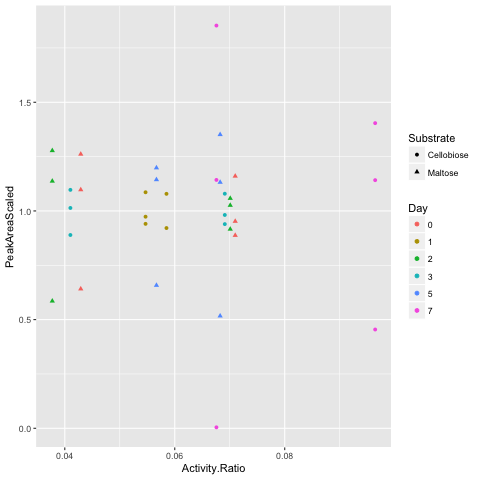

In [41]:
%%R

EnzMetab = d.melt.rm %>%
    group_by(Day,Class,Trtmt,Cmpd)%>%
    mutate(Baseline = mean(PeakArea))%>%
    mutate(PeakAreaScaled = PeakArea / Baseline)%>%
    filter(Cmpd=="maltose.cellobiose")
EnzActivity = read.csv("../R/Summary_enzymes_Kate.csv") %>%
    filter(Substrate==c("Maltose","Cellobiose"))%>%
    mutate(Trtmt=ifelse(Trtmt=="+N","N","X"))
EnzTest = merge(EnzActivity,EnzMetab,by=c("Day","Trtmt"))
EnzTest$Day = as.factor(EnzTest$Day)
p = ggplot(EnzTest, aes(x=Activity.Ratio,y=PeakAreaScaled, colour=Day, shape=Substrate))
p = p + geom_point()
p

In [64]:
%%R
head(EnzMetab)

Source: local data frame [6 x 4]
Groups: Day, Class [3]

     Day  Class  Trtmt PeakAreaScaled
  <fctr> <fctr> <fctr>          <dbl>
1      0  Sugar      N              1
2      0  Sugar      X              1
3      1  Sugar      N              1
4      1  Sugar      X              1
5      2  Sugar      N              1
6      2  Sugar      X              1


In [80]:
%%R
EnzActivity = read.csv("../R/Summary_enzymes_Kate.csv") %>%
   filter(Substrate %in% c("Maltose","Cellobiose","Xylobiose","Lactose"))
EnzActivity[1:20,]

   Trtmt Day  Substrate  Category Activity.Ratio       StDev
1     +N   0  Xylobiose Hydrolase     0.08630001 0.034739550
2     +N   1  Xylobiose Hydrolase     0.05981988 0.011638771
3     +N   2  Xylobiose Hydrolase     0.06646636 0.004674584
4     +N   3  Xylobiose Hydrolase     0.04041482 0.012155399
5     +N   5  Xylobiose Hydrolase     0.06965030 0.006914747
6     +N   7  Xylobiose Hydrolase     0.08541105 0.018312038
7      X   0  Xylobiose Hydrolase     0.06814862 0.007719091
8      X   1  Xylobiose Hydrolase     0.04673566 0.015634923
9      X   2  Xylobiose Hydrolase     0.04406324 0.007623520
10     X   3  Xylobiose Hydrolase     0.07122197 0.014002234
11     X   5  Xylobiose Hydrolase     0.06034494 0.006628194
12     X   7  Xylobiose Hydrolase     0.06967594 0.011015802
13    +N   0 Cellobiose Hydrolase     0.08963498 0.037237328
14    +N   1 Cellobiose Hydrolase     0.05468714 0.008627111
15    +N   2 Cellobiose Hydrolase     0.07038212 0.006162571
16    +N   3 Cellobiose 

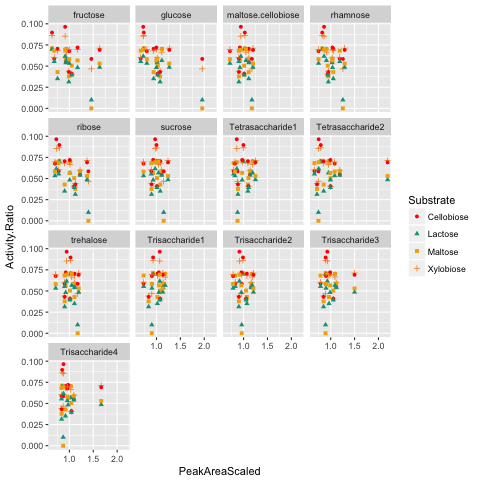

In [82]:
%%R

EnzMetab = d.melt.rm %>%
    group_by(Cmpd)%>%
    mutate(Baseline = mean(PeakArea))%>%
    mutate(PeakAreaScaled = PeakArea / Baseline)%>%
    group_by(Day,Class,Trtmt,Cmpd)%>%
    summarize(PeakAreaScaled = mean(PeakAreaScaled))%>%
    #filter(Cmpd=="maltose.cellobiose")
    filter(Class=="Sugar")
EnzActivity = read.csv("../R/Summary_enzymes_Kate.csv") %>%
    filter(Substrate %in% c("Maltose","Cellobiose","Xylobiose","Lactose"))%>%
    mutate(Trtmt=ifelse(Trtmt=="+N","N","X"))
EnzTest = merge(EnzActivity,EnzMetab,by=c("Day","Trtmt"))
EnzTest$Day = as.factor(EnzTest$Day)
#EnzTest = EnzTest[EnzTest$Day=="0",]
p = ggplot(EnzTest, aes(y=Activity.Ratio,x=PeakAreaScaled, colour=Substrate, shape=Substrate))
p = p + geom_point()
Palette = c(wes_palette("Darjeeling"),wes_palette("Darjeeling2"))
p = p + scale_colour_manual(values=Palette)
p = p + facet_wrap(~Cmpd)
p
# No strong evidence for relationships betwen enzyme activity and LC-MS substrate

In [85]:
%%R
    #filter(Class=="Sugar")
levels(read.csv("../R/Summary_enzymes_Kate.csv")$Substrate)

[1] "Cellobiose"         "Lactose"            "Maltose"           
[4] "Peroxidase"         "Polyphenol oxidase" "Xylobiose"         


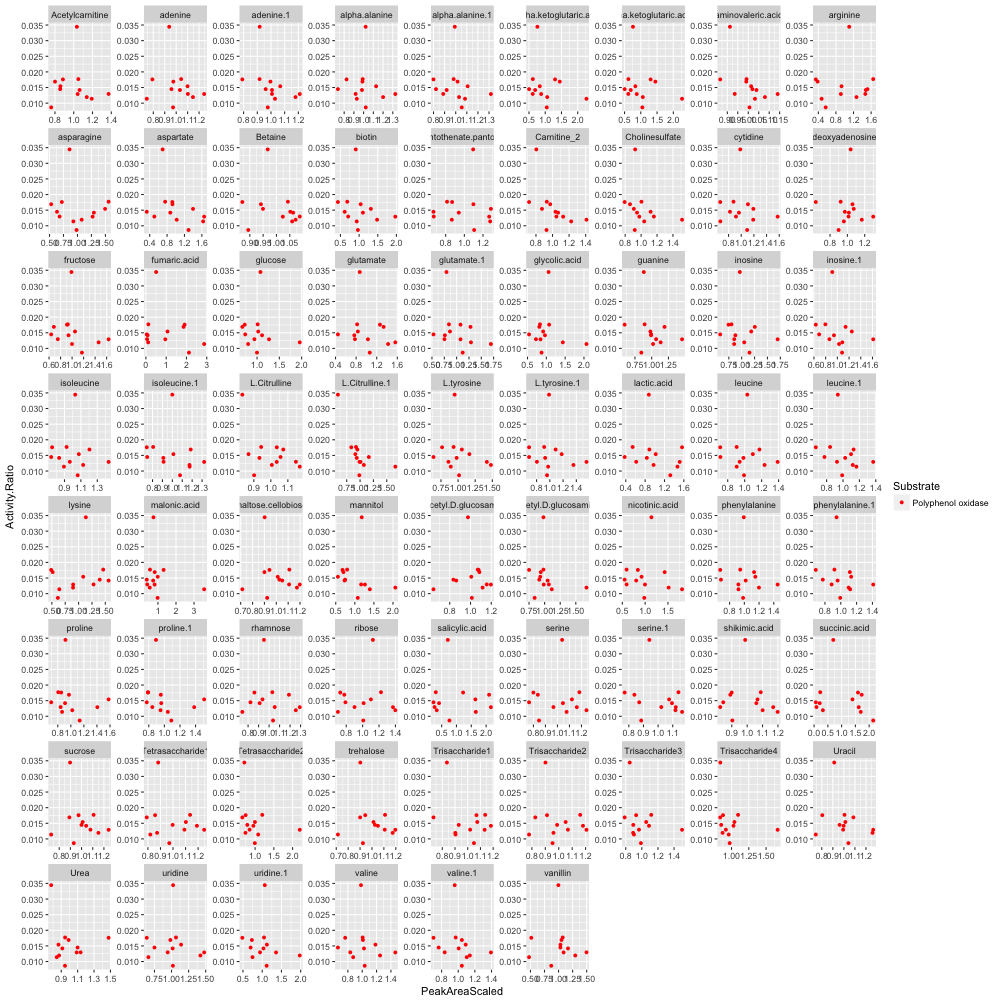

In [94]:
%%R -h 1000 -w 1000

EnzMetab = d.melt.rm %>%
    group_by(Cmpd)%>%
    mutate(Baseline = mean(PeakArea))%>%
    mutate(PeakAreaScaled = PeakArea / Baseline)%>%
    group_by(Day,Class,Trtmt,Cmpd)%>%
    summarize(PeakAreaScaled = mean(PeakAreaScaled))#%>%
    #filter(Cmpd=="vanillin")
    #filter(Class=="Sugar")
EnzActivity = read.csv("../R/Summary_enzymes_Kate.csv") %>%
    filter(Substrate %in% c("Polyphenol oxidase"))%>%
    mutate(Trtmt=ifelse(Trtmt=="+N","N","X"))
EnzTest = merge(EnzActivity,EnzMetab,by=c("Day","Trtmt"))
EnzTest$Day = as.factor(EnzTest$Day)
#EnzTest = EnzTest[EnzTest$Day=="0",]
p = ggplot(EnzTest, aes(y=Activity.Ratio,x=PeakAreaScaled, colour=Substrate, shape=Substrate))
p = p + geom_point()
Palette = c(wes_palette("Darjeeling"),wes_palette("Darjeeling2"))
p = p + scale_colour_manual(values=Palette)
p = p + facet_wrap(~Cmpd, scales="free")
p
# No strong evidence for relationships betwen enzyme activity and LC-MS substrate

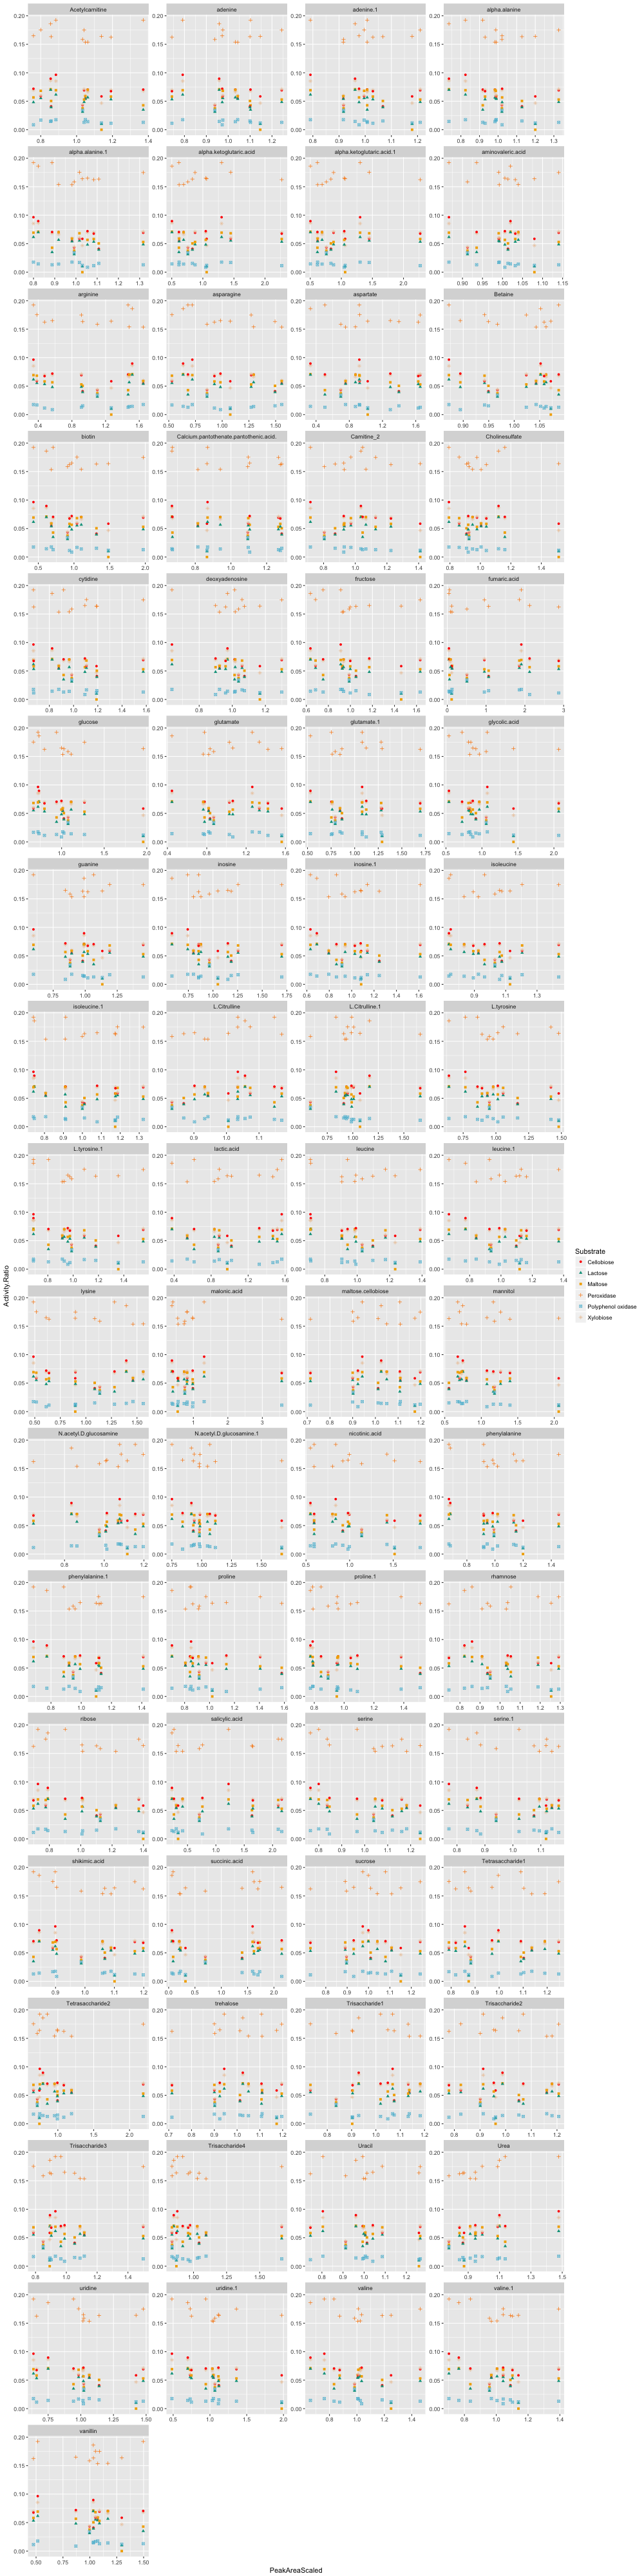

In [98]:
%%R -h 4000 -w 1000

EnzMetab = d.melt.rm %>%
    group_by(Cmpd)%>%
    mutate(Baseline = mean(PeakArea))%>%
    mutate(PeakAreaScaled = PeakArea / Baseline)%>%
    group_by(Day,Class,Trtmt,Cmpd)%>%
    summarize(PeakAreaScaled = mean(PeakAreaScaled))#%>%
    #filter(Cmpd=="vanillin")
    #filter(Class=="Sugar")
EnzActivity = read.csv("../R/Summary_enzymes_Kate.csv") %>%
    #filter(Substrate %in% c("Polyphenol oxidase","Peroxidase"))%>%
    mutate(Trtmt=ifelse(Trtmt=="+N","N","X"))
EnzTest = merge(EnzActivity,EnzMetab,by=c("Day","Trtmt"))
EnzTest$Day = as.factor(EnzTest$Day)
#EnzTest = EnzTest[EnzTest$Day=="0",]
p = ggplot(EnzTest, aes(y=Activity.Ratio,x=PeakAreaScaled, colour=Substrate, shape=Substrate))
p = p + geom_point()
Palette = c(wes_palette("Darjeeling"),wes_palette("Darjeeling2"))
p = p + scale_colour_manual(values=Palette)
p = p + facet_wrap(~Cmpd, scales="free", ncol=4)
p
# No strong evidence for relationships betwen enzyme activity and LC-MS substrate